<a href="https://colab.research.google.com/github/HNXJ/Jnwb/blob/main/jNWB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NWB file structure and usage

Data used: Visual Omission Oddball Paradigm

Bastoslab

github/hnyxj

## Initialization


### Packages

In [23]:
%pip install -U pynwb
%pip install -U pydrive

### Disk

Check directories

In [24]:
import os

# Print the current working directory
print(f"Current Working Directory: {os.getcwd()}")

# List files in the current directory to help identify location
print(f"Files in this directory: {os.listdir()[:10]}") # Limiting to first 10 for readability

Current Working Directory: /content
Files in this directory: ['.config', 'data', 'sample_data']


#### Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Box

In [ ]:
!apt-get install -y -qq rclone
!mkdir -p /content/box_mount
!pip install boxsdk

from boxsdk import Client, OAuth2
# Replace 'YOUR_DEVELOPER_TOKEN' with your actual token
access_token_user = 'YOUR_DEVELOPER_TOKEN'
oauth2 = OAuth2(client_id=None, client_secret=None, access_token=access_token_user)
client = Client(oauth2)

root_folder = client.folder(folder_id='0').get()
for item in root_folder.iter_items():
    print(f'{item.type.capitalize()}: {item.name}')

#### Docker

Install based on your system info:
https://docs.docker.com/get-started/get-docker/

then enter in terminal or cmd :
(source will be a directory path on your system)

docker run --gpus=all -p 127.0.0.1:9000:8080 --name colab_runtime_a --mount type=bind,source="D:\CDOC",target=/content/data us-docker.pkg.dev/colab-images/public/runtime


## Check NWB files

In [25]:
import os

filepath = "/content/data/reconstructed_nwbdata"

nwb_files = []
for file in os.listdir(filepath):
    if file.endswith(".nwb"):
        nwb_files.append(os.path.join(filepath, file))

print("Found NWB files:")
for nwb_file in nwb_files:
    print(nwb_file)

Found NWB files:
/content/data/reconstructed_nwbdata/sub-C31o_ses-230630_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230816_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230818_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230823_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230825_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230830_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230831_rec.nwb
/content/data/reconstructed_nwbdata/sub-C31o_ses-230901_rec.nwb
/content/data/reconstructed_nwbdata/sub-V198o_ses-230629_rec.nwb
/content/data/reconstructed_nwbdata/sub-V198o_ses-230714_rec.nwb
/content/data/reconstructed_nwbdata/sub-V198o_ses-230719_rec.nwb
/content/data/reconstructed_nwbdata/sub-V198o_ses-230720_rec.nwb
/content/data/reconstructed_nwbdata/sub-V198o_ses-230721_rec.nwb


### Load with pyNWB

In [47]:
from pynwb import NWBHDF5IO

filepath = nwb_files[1]

print(f"Inspecting file: {filepath}")

io = NWBHDF5IO(filepath, 'r')
nwb = io.read()
print("\n[General File Info]")
print(nwb)

Inspecting file: /content/data/reconstructed_nwbdata/sub-C31o_ses-230816_rec.nwb

[General File Info]
root pynwb.file.NWBFile at 0x139134367370800
Fields:
  acquisition: {
    eye_1_tracking <class 'pynwb.base.TimeSeries'>,
    photodiode_1_tracking <class 'pynwb.base.TimeSeries'>,
    probe_0_lfp <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_0_muae <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_1_lfp <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_1_muae <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_2_lfp <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_2_muae <class 'pynwb.ecephys.ElectricalSeries'>,
    pupil_1_tracking <class 'pynwb.base.TimeSeries'>,
    reward_1_tracking <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    probeA <class 'pynwb.device.Device'>,
    probeB <class 'pynwb.device.Device'>,
    probeC <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    probeA <class 'pynwb.ecephys.ElectrodeGroup'>,
    probeB <class 'pynwb.ecephys.Electr

### Task flow metadata

#### Conditions

In [35]:
target_interval = 'omission_glo_passive' # Task name in nwb.intervals
target_code_value = 1.0 # Corresponding value to find index
column_for_code = 'correct' # Code type column name in nwb.intervals.vector

# 1. Get the binary event array
correct_b = get_binary_events_for_code(
    nwb,
    target_code=1.0,
    target_interval_name=target_interval,
    code_column='correct'
)

stim1_b = get_binary_events_for_code(
    nwb,
    target_code=1,
    target_interval_name=target_interval,
    code_column='stimulus_number'
)

cond1_b = get_binary_events_for_code(
    nwb,
    target_code=1,
    target_interval_name=target_interval,
    code_column='task_condition_number'
)

print(f"Binary events array (first 10 elements): {correct_b[:10]}")
print(f"Total length of binary events array: {len(correct_b)}")

# 2. Use the binary array to get onset times
onset_times_from_binary = get_onset_time_bin(
    nwb,
    correct_b & cond1_b & stim1_b,
    target_interval_name=target_interval
)

print(f"Binary events array (first 10 elements): {cond1_b[:10]}")
print(f"Total length of binary events array: {len(cond1_b)}")

print(f"\nCorrect: {np.sum(correct_b)}")
print(f"Cond1: {np.sum(cond1_b)}")
print(f"All cond1 s1: {np.sum(correct_b & cond1_b & stim1_b)}")

print(f"\nTen initial onset times: {onset_times_from_binary[0:10]}")
print(f"Number of onset times found: {len(onset_times_from_binary)}")

Binary events array (first 10 elements): [1 1 1 1 1 1 1 1 1 1]
Total length of binary events array: 15586
Binary events array (first 10 elements): [1 1 1 1 1 1 1 1 1 1]
Total length of binary events array: 15586

Correct: 9210
Cond1: 576
All cond1 s1: 30

Ten initial onset times: [1371.9910666666667, 1379.3162, 1396.7748, 1418.0084666666667, 1475.8510666666666, 1483.2012, 1490.5596333333333, 1512.6433333333334, 1528.5352666666668, 1543.9938666666667]
Number of onset times found: 30


#### Behavioral signals

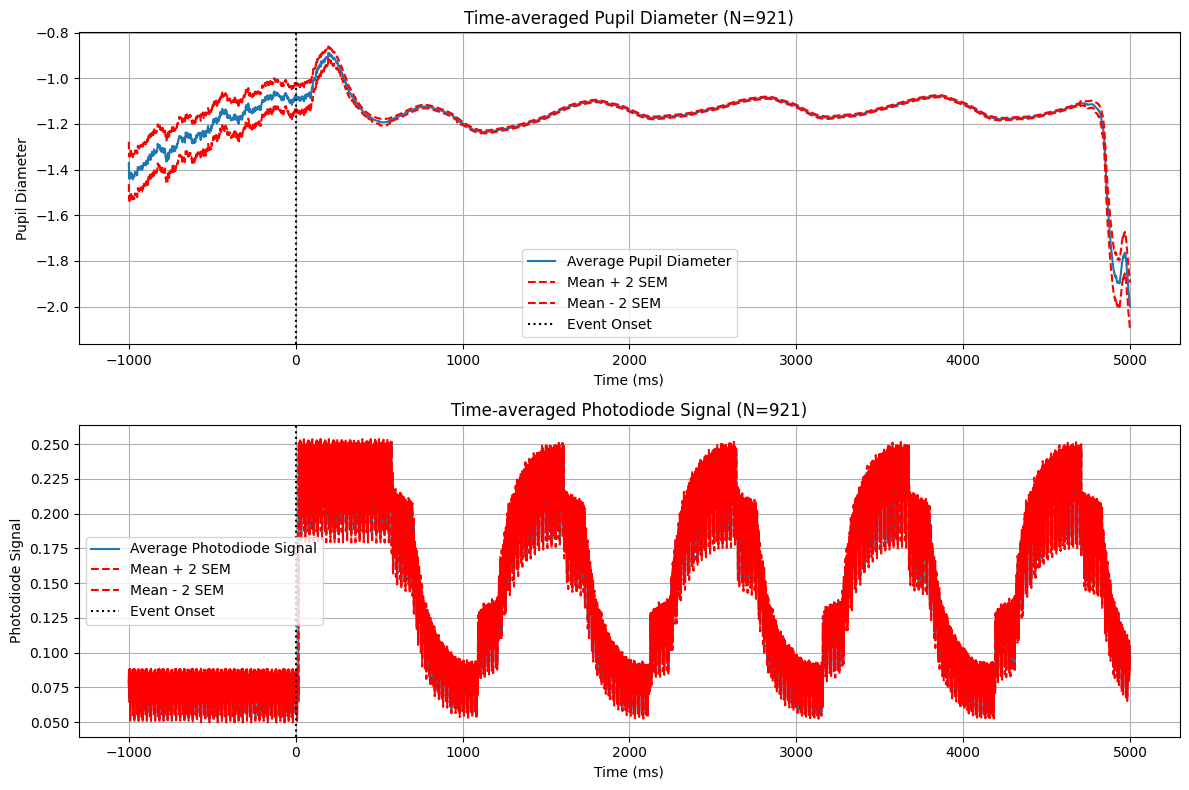

In [36]:
# Calculate onset_times_from_first_stim
target_interval = 'omission_glo_passive'

correct_b = get_binary_events_for_code(
    nwb,
    target_code=1.0,
    target_interval_name=target_interval,
    code_column='correct'
)

stim1_b = get_binary_events_for_code(
    nwb,
    target_code=1,
    target_interval_name=target_interval,
    code_column='stimulus_number'
)

onset_times_from_first_stim = get_onset_time_bin(
    nwb,
    correct_b & stim1_b,
    target_interval_name=target_interval
)

time_pre = 1.0
time_post = 5.0

pupil_aligned_data = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim,
    time_pre=time_pre,
    time_post=time_post,
    signal_mode='pupil'
)

photodiode_aligned_data = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim,
    time_pre=time_pre,
    time_post=time_post,
    signal_mode='photodiode'
)

# Calculate mean and SEM
pupil_mean = np.nanmean(pupil_aligned_data, axis=0)
pupil_sem = np.nanstd(pupil_aligned_data, axis=0) / np.sqrt(pupil_aligned_data.shape[0])

photodiode_mean = np.nanmean(photodiode_aligned_data, axis=0)
photodiode_sem = np.nanstd(photodiode_aligned_data, axis=0) / np.sqrt(photodiode_aligned_data.shape[0])

time_vector_ms = np.linspace(-time_pre * 1000, time_post * 1000, pupil_aligned_data.shape[1])

N_events = pupil_aligned_data.shape[0]

plt.figure(figsize=(12, 8))

# Plot Pupil Data
plt.subplot(2, 1, 1)
plt.plot(time_vector_ms, pupil_mean, label='Average Pupil Diameter')
plt.plot(time_vector_ms, pupil_mean + 2 * pupil_sem, 'r--', label='Mean + 2 SEM')
plt.plot(time_vector_ms, pupil_mean - 2 * pupil_sem, 'r--', label='Mean - 2 SEM')
plt.axvline(0, color='k', linestyle=':', label='Event Onset')
plt.xlabel('Time (ms)')
plt.ylabel('Pupil Diameter')
plt.title(f'Time-averaged Pupil Diameter (N={N_events})')
plt.legend()
plt.grid(True)

# Plot Photodiode Data
plt.subplot(2, 1, 2)
plt.plot(time_vector_ms, photodiode_mean, label='Average Photodiode Signal')
plt.plot(time_vector_ms, photodiode_mean + 2 * photodiode_sem, 'r--', label='Mean + 2 SEM')
plt.plot(time_vector_ms, photodiode_mean - 2 * photodiode_sem, 'r--', label='Mean - 2 SEM')
plt.axvline(0, color='k', linestyle=':', label='Event Onset')
plt.xlabel('Time (ms)')
plt.ylabel('Photodiode Signal')
plt.title(f'Time-averaged Photodiode Signal (N={N_events})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### LFP signals

/tmp/ipython-input-3257119568.py:73: RuntimeWarning: Mean of empty slice
  lfp_mean_aaab_per_event = np.nanmean(lfp_aligned_data_aaab, axis=2)
/tmp/ipython-input-3257119568.py:88: RuntimeWarning: Mean of empty slice
  lfp_mean_bbba_per_event = np.nanmean(lfp_aligned_data_bbba, axis=2)


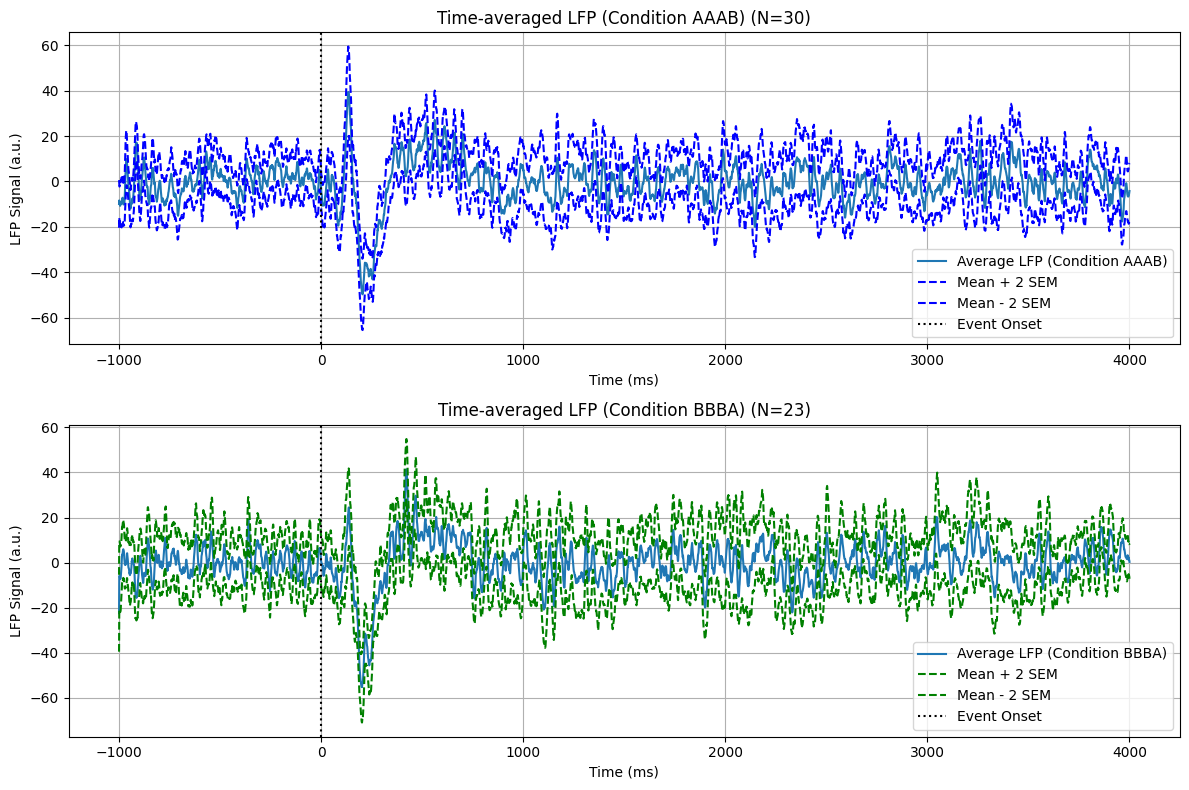

In [39]:
import numpy as np
import matplotlib.pyplot as plt

target_interval = 'omission_glo_passive'

correct_b = get_binary_events_for_code(
    nwb,
    target_code=1.0,
    target_interval_name=target_interval,
    code_column='correct'
)

stim1_b = get_binary_events_for_code(
    nwb,
    target_code=1,
    target_interval_name=target_interval,
    code_column='stimulus_number'
)

aaab_b = get_binary_events_for_code(
    nwb,
    target_code=1,
    target_interval_name=target_interval,
    code_column='task_condition_number'
)

bbba_b = get_binary_events_for_code(
    nwb,
    target_code=5,
    target_interval_name=target_interval,
    code_column='task_condition_number'
)

onset_times_from_first_stim_aaab = get_onset_time_bin(
    nwb,
    correct_b & stim1_b & aaab_b,
    target_interval_name=target_interval
)

onset_times_from_first_stim_bbba = get_onset_time_bin(
    nwb,
    correct_b & stim1_b & bbba_b,
    target_interval_name=target_interval
)

time_pre = 1.0
time_post = 4.0

lfp_aligned_data_aaab = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim_aaab,
    time_pre=time_pre,
    time_post=time_post,
    signal_mode='lfp'
)

lfp_aligned_data_bbba = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim_bbba,
    time_pre=time_pre,
    time_post=time_post,
    signal_mode='lfp'
)

# Calculate mean and SEM across channels first, then across trials
# For LFP, we often want to see the mean across channels, or a specific channel. For now, average across channels.
# If lfp_aligned_data is 3D (events, timepoints, channels), we average across channels to get (events, timepoints)

# Handle potential empty arrays if no events were found for a condition
if lfp_aligned_data_aaab.size > 0:
    # If multi-channel, average across channels first
    if lfp_aligned_data_aaab.ndim == 3:
        lfp_mean_aaab_per_event = np.nanmean(lfp_aligned_data_aaab, axis=2)
    else:
        lfp_mean_aaab_per_event = lfp_aligned_data_aaab # Already 2D (events, timepoints)

    lfp_mean_aaab = np.nanmean(lfp_mean_aaab_per_event, axis=0)
    lfp_sem_aaab = np.nanstd(lfp_mean_aaab_per_event, axis=0) / np.sqrt(lfp_mean_aaab_per_event.shape[0])
    N_events_aaab = lfp_mean_aaab_per_event.shape[0]
else:
    lfp_mean_aaab = np.array([])
    lfp_sem_aaab = np.array([])
    N_events_aaab = 0

if lfp_aligned_data_bbba.size > 0:
    # If multi-channel, average across channels first
    if lfp_aligned_data_bbba.ndim == 3:
        lfp_mean_bbba_per_event = np.nanmean(lfp_aligned_data_bbba, axis=2)
    else:
        lfp_mean_bbba_per_event = lfp_aligned_data_bbba # Already 2D (events, timepoints)

    lfp_mean_bbba = np.nanmean(lfp_mean_bbba_per_event, axis=0)
    lfp_sem_bbba = np.nanstd(lfp_mean_bbba_per_event, axis=0) / np.sqrt(lfp_mean_bbba_per_event.shape[0])
    N_events_bbba = lfp_mean_bbba_per_event.shape[0]
else:
    lfp_mean_bbba = np.array([])
    lfp_sem_bbba = np.array([])
    N_events_bbba = 0

# Time vector for plotting (in milliseconds)
# Assuming both LFP aligned data arrays have the same second dimension for time points
if lfp_aligned_data_aaab.size > 0:
    time_vector_ms = np.linspace(-time_pre * 1000, time_post * 1000, lfp_mean_aaab.shape[0])
elif lfp_aligned_data_bbba.size > 0:
    time_vector_ms = np.linspace(-time_pre * 1000, time_post * 1000, lfp_mean_bbba.shape[0])
else:
    time_vector_ms = np.array([])

plt.figure(figsize=(12, 8))

# Plot LFP aaab
plt.subplot(2, 1, 1)
if lfp_mean_aaab.size > 0:
    plt.plot(time_vector_ms, lfp_mean_aaab, label='Average LFP (Condition AAAB)')
    plt.plot(time_vector_ms, lfp_mean_aaab + 2 * lfp_sem_aaab, 'b--', label='Mean + 2 SEM')
    plt.plot(time_vector_ms, lfp_mean_aaab - 2 * lfp_sem_aaab, 'b--', label='Mean - 2 SEM')
    plt.axvline(0, color='k', linestyle=':', label='Event Onset')
    plt.xlabel('Time (ms)')
    plt.ylabel('LFP Signal (a.u.)')
    plt.title(f'Time-averaged LFP (Condition AAAB) (N={N_events_aaab})')
    plt.legend()
plt.grid(True)

# Plot LFP bbba
plt.subplot(2, 1, 2)
if lfp_mean_bbba.size > 0:
    plt.plot(time_vector_ms, lfp_mean_bbba, label='Average LFP (Condition BBBA)')
    plt.plot(time_vector_ms, lfp_mean_bbba + 2 * lfp_sem_bbba, 'g--', label='Mean + 2 SEM')
    plt.plot(time_vector_ms, lfp_mean_bbba - 2 * lfp_sem_bbba, 'g--', label='Mean - 2 SEM')
    plt.axvline(0, color='k', linestyle=':', label='Event Onset')
    plt.xlabel('Time (ms)')
    plt.ylabel('LFP Signal (a.u.)')
    plt.title(f'Time-averaged LFP (Condition BBBA) (N={N_events_bbba})')
    plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### MUAe signals

/tmp/ipython-input-4262140148.py:32: RuntimeWarning: Mean of empty slice
  muae_mean_aaab_per_event = np.nanmean(muae_aligned_data_aaab, axis=2)
/tmp/ipython-input-4262140148.py:47: RuntimeWarning: Mean of empty slice
  muae_mean_bbba_per_event = np.nanmean(muae_aligned_data_bbba, axis=2)


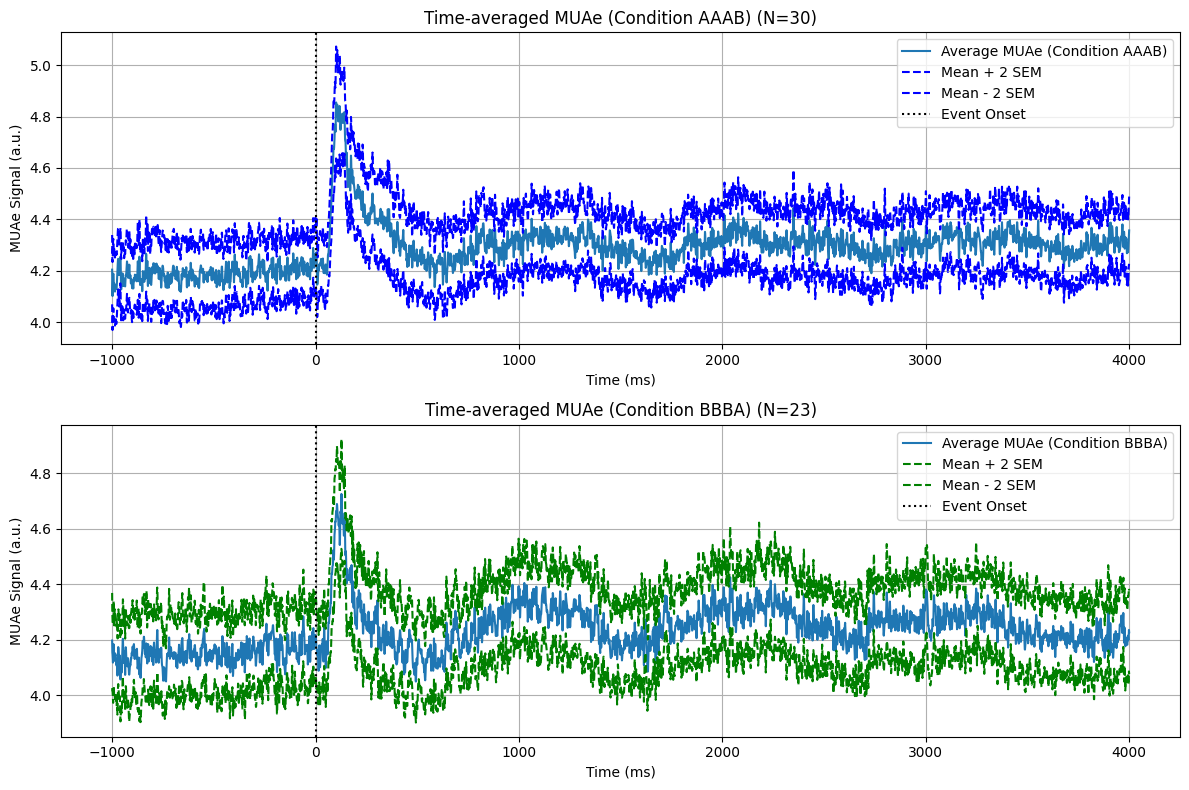

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming nwb, get_binary_events_for_code, get_onset_time_bin, get_signal_array
# and other variables like target_interval, correct_b, stim1_b, aaab_b, bbba_b,
# onset_times_from_first_stim_aaab, onset_times_from_first_stim_bbba,
# time_pre, time_post are already defined in the kernel from previous executions.

# Fetch MUAe aligned data for both conditions

muae_aligned_data_aaab = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim_aaab,
    time_pre=time_pre,
    time_post=time_post,
    signal_mode='muae'
)

muae_aligned_data_bbba = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim_bbba,
    time_pre=time_pre,
    time_post=time_post,
    signal_mode='muae'
)

# Calculate mean and SEM across channels first, then across trials
# Handle potential empty arrays if no events were found for a condition
if muae_aligned_data_aaab.size > 0:
    # If multi-channel, average across channels first
    if muae_aligned_data_aaab.ndim == 3:
        muae_mean_aaab_per_event = np.nanmean(muae_aligned_data_aaab, axis=2)
    else:
        muae_mean_aaab_per_event = muae_aligned_data_aaab # Already 2D (events, timepoints)

    muae_mean_aaab = np.nanmean(muae_mean_aaab_per_event, axis=0)
    muae_sem_aaab = np.nanstd(muae_mean_aaab_per_event, axis=0) / np.sqrt(muae_mean_aaab_per_event.shape[0])
    N_events_aaab = muae_mean_aaab_per_event.shape[0]
else:
    muae_mean_aaab = np.array([])
    muae_sem_aaab = np.array([])
    N_events_aaab = 0

if muae_aligned_data_bbba.size > 0:
    # If multi-channel, average across channels first
    if muae_aligned_data_bbba.ndim == 3:
        muae_mean_bbba_per_event = np.nanmean(muae_aligned_data_bbba, axis=2)
    else:
        muae_mean_bbba_per_event = muae_aligned_data_bbba # Already 2D (events, timepoints)

    muae_mean_bbba = np.nanmean(muae_mean_bbba_per_event, axis=0)
    muae_sem_bbba = np.nanstd(muae_mean_bbba_per_event, axis=0) / np.sqrt(muae_mean_bbba_per_event.shape[0])
    N_events_bbba = muae_mean_bbba_per_event.shape[0]
else:
    muae_mean_bbba = np.array([])
    muae_sem_bbba = np.array([])
    N_events_bbba = 0

# Time vector for plotting (in milliseconds)
# Assuming both MUAe aligned data arrays have the same second dimension for time points
if muae_aligned_data_aaab.size > 0:
    time_vector_ms = np.linspace(-time_pre * 1000, time_post * 1000, muae_mean_aaab.shape[0])
elif muae_aligned_data_bbba.size > 0:
    time_vector_ms = np.linspace(-time_pre * 1000, time_post * 1000, muae_mean_bbba.shape[0])
else:
    time_vector_ms = np.array([])

plt.figure(figsize=(12, 8))

# Plot MUAe aaab
plt.subplot(2, 1, 1)
if muae_mean_aaab.size > 0:
    plt.plot(time_vector_ms, muae_mean_aaab, label='Average MUAe (Condition AAAB)')
    plt.plot(time_vector_ms, muae_mean_aaab + 2 * muae_sem_aaab, 'b--', label='Mean + 2 SEM')
    plt.plot(time_vector_ms, muae_mean_aaab - 2 * muae_sem_aaab, 'b--', label='Mean - 2 SEM')
    plt.axvline(0, color='k', linestyle=':', label='Event Onset')
    plt.xlabel('Time (ms)')
    plt.ylabel('MUAe Signal (a.u.)')
    plt.title(f'Time-averaged MUAe (Condition AAAB) (N={N_events_aaab})')
    plt.legend()
plt.grid(True)

# Plot MUAe bbba
plt.subplot(2, 1, 2)
if muae_mean_bbba.size > 0:
    plt.plot(time_vector_ms, muae_mean_bbba, label='Average MUAe (Condition BBBA)')
    plt.plot(time_vector_ms, muae_mean_bbba + 2 * muae_sem_bbba, 'g--', label='Mean + 2 SEM')
    plt.plot(time_vector_ms, muae_mean_bbba - 2 * muae_sem_bbba, 'g--', label='Mean - 2 SEM')
    plt.axvline(0, color='k', linestyle=':', label='Event Onset')
    plt.xlabel('Time (ms)')
    plt.ylabel('MUAe Signal (a.u.)')
    plt.title(f'Time-averaged MUAe (Condition BBBA) (N={N_events_bbba})')
    plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Single neuron signals

[SNR Data (First 10 values)]


,snr
id,
0,0.10907854129296
1,0.0758073072790253
2,0.4541941252863773
3,0.584932826944976
4,0.8595105695491922
5,0.5522921629224218
6,1.0312894567115212
7,0.4630029135529659
8,0.0416680012544429


Total SNR values: 357


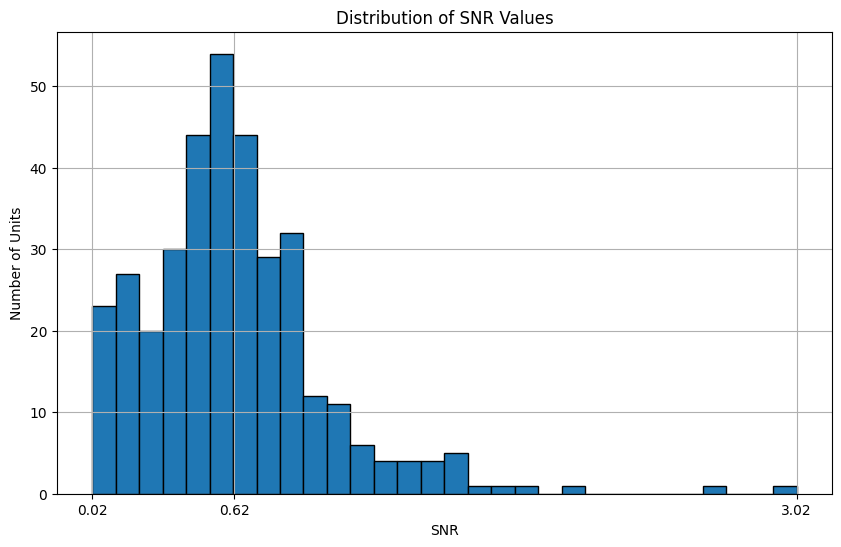

In [56]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy for mean calculation if not already imported
import pandas as pd # Import pandas as it's used for pd.to_numeric

snr_data = get_unit_column_data(nwb, 'snr')

if snr_data is not None:
    # Ensure data is numeric and handle potential NaNs for calculations
    numeric_snr_data = pd.to_numeric(snr_data, errors='coerce').dropna()
    # Filter out infinite values to ensure finite range for histogram
    numeric_snr_data = numeric_snr_data[np.isfinite(numeric_snr_data)]

    if numeric_snr_data.empty: # Handle case where all data might be inf/NaN/empty
        print("No finite SNR data available for plotting.")
    else:
        print("[SNR Data (First 10 values)]")
        display(snr_data.head(10))
        print(f"Total SNR values: {len(snr_data)}")

        # Calculate min, max, and mean SNR
        snr_min = numeric_snr_data.min()
        snr_max = numeric_snr_data.max()
        snr_mean = numeric_snr_data.mean()

        # Define x-axis ticks
        x_ticks = [snr_min, snr_mean, snr_max]
        x_labels = [f'{val:.2f}' for val in x_ticks] # Format for readability

        # Plot histogram of SNR data
        plt.figure(figsize=(10, 6))
        plt.hist(numeric_snr_data, bins=30, edgecolor='black')
        plt.title('Distribution of SNR Values')
        plt.xlabel('SNR')
        plt.ylabel('Number of Units')

        # Set custom x-axis ticks and labels
        plt.xticks(x_ticks, x_labels)

        plt.grid(True)
        plt.show()
else:
    print("Could not retrieve SNR data.")

##### Single neuron metadata

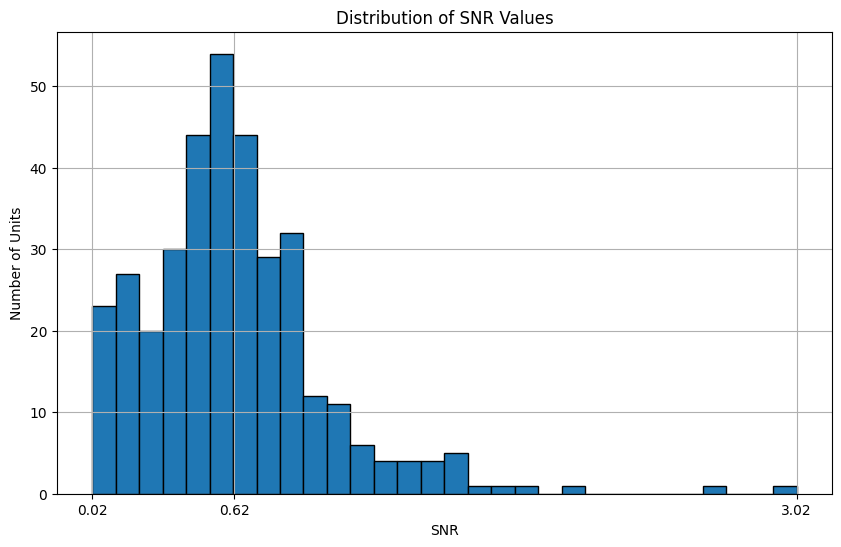

In [58]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy for mean calculation if not already imported
import pandas as pd # Import pandas as it's used for pd.to_numeric

snr_data = get_unit_column_data(nwb, 'snr')

if snr_data is not None:
    # Ensure data is numeric and handle potential NaNs for calculations
    numeric_snr_data = pd.to_numeric(snr_data, errors='coerce').dropna()
    # Filter out infinite values to ensure finite range for histogram
    numeric_snr_data = numeric_snr_data[np.isfinite(numeric_snr_data)]

    if numeric_snr_data.empty: # Handle case where all data might be inf/NaN/empty
        print("No finite SNR data available for plotting.")
    else:
        # Calculate min, max, and mean SNR
        snr_min = numeric_snr_data.min()
        snr_max = numeric_snr_data.max()
        snr_mean = numeric_snr_data.mean()

        # Define x-axis ticks
        x_ticks = [snr_min, snr_mean, snr_max]
        x_labels = [f'{val:.2f}' for val in x_ticks] # Format for readability

        # Plot histogram of SNR data
        plt.figure(figsize=(10, 6))
        plt.hist(numeric_snr_data, bins=30, edgecolor='black')
        plt.title('Distribution of SNR Values')
        plt.xlabel('SNR')
        plt.ylabel('Number of Units')

        # Set custom x-axis ticks and labels
        plt.xticks(x_ticks, x_labels)

        plt.grid(True)
        plt.show()
else:
    print("Could not retrieve SNR data.")

##### Single neuron spiking signals

Signal visualizations

## Functions

### Utility

In [57]:
import uuid
import h5py
import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile, NWBHDF5IO, TimeSeries
from pynwb.ecephys import LFP, ElectricalSeries, ElectrodeGroup

from hdmf.data_utils import DataChunkIterator
from hdmf.backends.hdf5 import H5DataIO
from pynwb.file import Subject
from pynwb.misc import Units

import os
import matplotlib.pyplot as plt


def inspect_h5py_raw_structure(filepath, max_display_elements=5):
    """
    Recursively inspects a raw HDF5 file (e.g., an NWB file) using h5py,
    printing its group and dataset structure.

    Args:
        filepath (str): The path to the HDF5 file.
        max_display_elements (int): Maximum number of elements to display for small arrays.
    """

    def _print_item(name, obj, indent=0):
        indent_str = '  ' * indent
        if isinstance(obj, h5py.Group):
            print(f"{indent_str}Group: {name}/")
            for key, val in obj.items():
                _print_item(key, val, indent + 1)
        elif isinstance(obj, h5py.Dataset):
            value_info = f"Shape: {obj.shape}, Dtype: {obj.dtype}"
            if obj.size <= max_display_elements and obj.ndim <= 1: # Only display small 1D datasets directly
                try:
                    value_info += f", Value: {obj[()]}"
                except Exception as e:
                    value_info += f" (Error reading value: {e})"
            print(f"{indent_str}Dataset: {name} ({value_info})")
        else:
            print(f"{indent_str}Unknown: {name} (Type: {type(obj).__name__})")

    print(f"\n--- Inspecting Raw HDF5 Structure of: {filepath} ---")
    try:
        with h5py.File(filepath, 'r') as f:
            _print_item(f.name, f, indent=0)
    except Exception as e:
        print(f"Error accessing HDF5 file: {e}")
    print("--- End Raw HDF5 Inspection ---")


def reconstruct_nwb_inspected(source_filepath, target_filepath):
    """
    Inspects the raw HDF5 structure and simultaneously reconstructs a valid NWBFile.
    Attempts to preserve the structure of acquisition, processing, stimulus, and metadata.
    """
    print(f"--- Reconstructing with Inspection: {source_filepath} -> {target_filepath} ---")

    def _safe_decode(val):
        if val is None: return None
        if isinstance(val, (bytes, np.bytes_)):
            return val.decode('utf-8')
        if isinstance(val, np.ndarray):
            if val.ndim == 0: return _safe_decode(val.item())
            return [_safe_decode(v) for v in val]
        return str(val)

    with h5py.File(source_filepath, 'r') as f:
        # 1. General Metadata
        print("Inspecting: / (Root Metadata)")
        sst_str = _safe_decode(f.get('session_start_time')[()]) if 'session_start_time' in f else None
        try:
            clean_str = sst_str.strip("b'").strip('"')
            session_start_time = datetime.fromisoformat(clean_str)
        except:
            session_start_time = datetime.now(tzlocal())

        identifier = str(uuid.uuid4())
        desc = _safe_decode(f.get('general/experiment_description')[()]) if 'general/experiment_description' in f else "Reconstructed"
        session_id = _safe_decode(f.get('general/session_id')[()]) if 'general/session_id' in f else None

        metadata_fields = {
            'notes': f.get('general/notes'),
            'pharmacology': f.get('general/pharmacology'),
            'protocol': f.get('general/protocol'),
            'surgery': f.get('general/surgery'),
            'virus': f.get('general/virus'),
            'slices': f.get('general/slices'),
            'data_collection': f.get('general/data_collection'),
            'stimulus_notes': f.get('general/stimulus')
        }

        nwb_kwargs = {}
        for key, dset in metadata_fields.items():
            if dset is not None:
                val = _safe_decode(dset[()])
                if val:
                    nwb_kwargs[key] = val

        subject = None
        if 'general/subject' in f:
            print("  - Found Subject metadata")
            subj_grp = f['general/subject']
            subject = Subject(
                subject_id=_safe_decode(subj_grp.get('subject_id')[()]) if 'subject_id' in subj_grp else 'unknown',
                description=_safe_decode(subj_grp.get('description')[()]) if 'description' in subj_grp else None,
                species=_safe_decode(subj_grp.get('species')[()]) if 'species' in subj_grp else None,
                sex=_safe_decode(subj_grp.get('sex')[()]) if 'sex' in subj_grp else None,
                age=_safe_decode(subj_grp.get('age')[()]) if 'age' in subj_grp else None
            )

        nwbfile = NWBFile(
            session_description=desc,
            identifier=identifier,
            session_start_time=session_start_time,
            institution=_safe_decode(f.get('general/institution')[()]) if 'general/institution' in f else None,
            lab=_safe_decode(f.get('general/lab')[()]) if 'general/lab' in f else None,
            experimenter=_safe_decode(f.get('general/experimenter')[()]) if 'general/experimenter' in f else None,
            session_id=session_id,
            subject=subject,
            **nwb_kwargs
        )

        # 2. Devices & Electrodes
        print("Inspecting: /general/devices & /general/extracellular_ephys")
        device_map = {}
        if 'general/devices' in f:
            for dev_name in f['general/devices']:
                device_map[dev_name] = nwbfile.create_device(name=dev_name)
        if not device_map: device_map['default'] = nwbfile.create_device(name='default_device')

        eg_map = {}
        if 'general/extracellular_ephys' in f:
            ephys = f['general/extracellular_ephys']
            for key in ephys:
                if key == 'electrodes': continue
                dev = list(device_map.values())[0]
                eg_map[key] = nwbfile.create_electrode_group(name=key, description=key, location="unknown", device=dev)

        if 'general/extracellular_ephys/electrodes' in f:
            elec_dset = f['general/extracellular_ephys/electrodes']
            ids = elec_dset['id'][:]

            std_cols = ['id', 'x', 'y', 'z', 'imp', 'location', 'filtering', 'group']
            extra_cols = [k for k in elec_dset.keys() if k not in std_cols and isinstance(elec_dset[k], h5py.Dataset)]

            for col in extra_cols:
                curr_colnames = nwbfile.electrodes.colnames if nwbfile.electrodes else ()
                if col not in curr_colnames:
                    desc = "N/A"
                    if 'description' in elec_dset[col].attrs:
                        desc = _safe_decode(elec_dset[col].attrs['description'])
                    nwbfile.add_electrode_column(name=col, description=desc)

            for i in range(len(ids)):
                eg_name = 'default'
                try: eg_name = f[elec_dset['group'][i]].name.split('/')[-1]
                except: pass
                eg = eg_map.get(eg_name, list(eg_map.values())[0] if eg_map else nwbfile.create_electrode_group('default', 'auto', 'unknown', list(device_map.values())[0]))

                base_kwargs = {
                    'id': ids[i],
                    'x': elec_dset['x'][i] if 'x' in elec_dset else np.nan,
                    'y': elec_dset['y'][i] if 'y' in elec_dset else np.nan,
                    'z': elec_dset['z'][i] if 'z' in elec_dset else np.nan,
                    'imp': elec_dset['imp'][i] if 'imp' in elec_dset else np.nan,
                    'location': _safe_decode(elec_dset['location'][i]) if 'location' in elec_dset else 'unknown',
                    'filtering': _safe_decode(elec_dset['filtering'][i]) if 'filtering' in elec_dset else 'unknown',
                    'group': eg
                }
                for col in extra_cols:
                    base_kwargs[col] = _safe_decode(elec_dset[col][i])
                nwbfile.add_electrode(**base_kwargs)
        else:
            dev = list(device_map.values())[0]
            eg = nwbfile.create_electrode_group('dummy', 'dummy', 'unknown', dev)
            nwbfile.add_electrode(id=0, x=0.0, y=0.0, z=0.0, imp=0.0, location='unknown', filtering='none', group=eg)

        # 3. Intervals
        if 'intervals' in f:
            print("Inspecting: /intervals")
            for key in f['intervals']:
                print(f"  - Found Interval: {key}")
                grp = f['intervals'][key]
                ti = nwbfile.create_time_intervals(name=key, description=f"Intervals for {key}")
                colnames = [k for k in grp.keys() if k not in ['id', 'start_time', 'stop_time'] and isinstance(grp[k], h5py.Dataset)]
                for col in colnames: ti.add_column(name=col, description=col)
                for i in range(len(grp['id'])):
                    row = {'start_time': grp['start_time'][i], 'stop_time': grp['stop_time'][i]}
                    for col in colnames: row[col] = _safe_decode(grp[col][i])
                    ti.add_row(**row)

        # 4. Units
        if 'units' in f:
            print("Inspecting: /units")
            grp = f['units']

            units_desc = "N/A"
            if 'description' in grp.attrs:
                units_desc = _safe_decode(grp.attrs['description'])

            if nwbfile.units is None:
                nwbfile.units = Units(name='units', description=units_desc)
            else:
                nwbfile.units.description = units_desc

            if 'id' in grp:
                ids = grp['id'][:]
                col_names = [k for k in grp.keys() if isinstance(grp[k], h5py.Dataset) and k != 'id' and not k.endswith('_index')]
                for col in col_names:
                    if col == 'spike_times': continue
                    curr_colnames = nwbfile.units.colnames if nwbfile.units else ()
                    if col not in curr_colnames:
                        desc = "N/A"
                        if 'description' in grp[col].attrs:
                             desc = _safe_decode(grp[col].attrs['description'])
                        nwbfile.add_unit_column(name=col, description=desc)

                st_data = grp['spike_times'][:] if 'spike_times' in grp else None
                st_index = grp['spike_times_index'][:] if 'spike_times_index' in grp else None

                for i, unit_id in enumerate(ids):
                    row_data = {'id': unit_id}
                    for col in col_names:
                        if col == 'spike_times': continue
                        row_data[col] = _safe_decode(grp[col][i])
                    if st_data is not None and st_index is not None:
                        start = st_index[i-1] if i > 0 else 0
                        end = st_index[i]
                        row_data['spike_times'] = st_data[start:end]
                    elif st_data is not None and st_index is None and len(ids) == 1:
                         row_data['spike_times'] = st_data
                    nwbfile.add_unit(**row_data)

        # 5. Acquisition
        if 'acquisition' in f:
            print("Inspecting: /acquisition")
            for key in f['acquisition']:
                print(f"  - Found Acquisition: {key}")
                grp = f['acquisition'][key]
                target_grp = None

                if key + '_data' in grp: target_grp = grp[key + '_data']
                elif 'data' in grp: target_grp = grp
                else:
                     for sub_key in grp:
                         sub_item = grp[sub_key]
                         if isinstance(sub_item, h5py.Group) and 'data' in sub_item and 'timestamps' in sub_item:
                             target_grp = sub_item
                             break

                if target_grp and 'data' in target_grp and 'timestamps' in target_grp:
                    dset = target_grp['data']
                    ts = target_grp['timestamps']

                    if 'lfp' in key.lower() or 'muae' in key.lower():
                        if 'electrodes' in target_grp: elec_idxs = target_grp['electrodes'][:]
                        else: elec_idxs = list(range(min(dset.shape[1], len(nwbfile.electrodes))))
                        elec_region = nwbfile.create_electrode_table_region(region=list(range(len(elec_idxs))), description=f"Electrodes for {key}")
                        es = ElectricalSeries(name=key, data=DataChunkIterator(dset, buffer_size=20000), timestamps=DataChunkIterator(ts, buffer_size=20000), electrodes=elec_region, description=f"Reconstructed {key}")
                        nwbfile.add_acquisition(es)
                    else:
                        ts_obj = TimeSeries(name=key, data=DataChunkIterator(dset, buffer_size=20000), timestamps=DataChunkIterator(ts, buffer_size=20000), unit='unknown', description=f"Reconstructed {key}")
                        nwbfile.add_acquisition(ts_obj)

        # 6. Processing
        if 'processing' in f:
            print("Inspecting: /processing")
            for mod_key in f['processing']:
                print(f"  - Found Module: {mod_key}")
                desc = f"Reconstructed {mod_key}"
                proc_mod = nwbfile.create_processing_module(name=mod_key, description=desc)
                mod_grp = f['processing'][mod_key]
                for sub_key in mod_grp:
                    sub_item = mod_grp[sub_key]
                    if isinstance(sub_item, h5py.Group) and 'data' in sub_item and 'timestamps' in sub_item:
                        dset = sub_item['data']
                        ts = sub_item['timestamps']
                        ts_obj = TimeSeries(name=sub_key, data=DataChunkIterator(dset, buffer_size=20000), timestamps=DataChunkIterator(ts, buffer_size=20000), unit='unknown', description=f"Reconstructed from {mod_key}/{sub_key}")
                        proc_mod.add(ts_obj)

                if mod_key == 'spike_train' and (nwbfile.units is None or len(nwbfile.units) == 0):
                     print(f"    -> Populating Units from {mod_key} (Alternative Source)")
                     try:
                         sub_key = mod_key + '_data'
                         if sub_key in mod_grp:
                             data_node = mod_grp[sub_key]['data']
                             ts_node = mod_grp[sub_key]['timestamps']
                             spike_data = data_node[:]
                             timestamps = ts_node[:]
                             elec_map = None
                             if 'electrodes' in mod_grp[sub_key]:
                                 elec_map = mod_grp[sub_key]['electrodes'][:]
                                 nwbfile.add_unit_column(name='electrode_id', description='Electrode ID from spike_train')
                             n_units = spike_data.shape[1]
                             for u in range(n_units):
                                 spikes = timestamps[np.nonzero(spike_data[:, u])[0]]
                                 extra_kwargs = {}
                                 if elec_map is not None and u < len(elec_map): extra_kwargs['electrode_id'] = int(elec_map[u])
                                 nwbfile.add_unit(spike_times=spikes, id=u, **extra_kwargs)
                     except Exception as e:
                         print(f"Error processing spike train units {mod_key}: {e}")

        # 7. Stimulus
        if 'stimulus' in f:
            print("Inspecting: /stimulus")
            if 'presentation' in f['stimulus']:
                print("  - Found presentation")
                stim_grp = f['stimulus']['presentation']
                for key in stim_grp:
                     if isinstance(stim_grp[key], h5py.Group) and 'data' in stim_grp[key] and 'timestamps' in stim_grp[key]:
                         dset = stim_grp[key]['data']
                         ts = stim_grp[key]['timestamps']
                         ts_obj = TimeSeries(name=key, data=DataChunkIterator(dset, buffer_size=20000), timestamps=DataChunkIterator(ts, buffer_size=20000), unit='unknown', description=f"Reconstructed stimulus {key}")
                         nwbfile.add_stimulus(ts_obj)

        # 8. Scratch
        if 'scratch' in f:
             print("Inspecting: /scratch")
             scratch_grp = f['scratch']
             for key in scratch_grp:
                 if isinstance(scratch_grp[key], h5py.Dataset):
                     print(f"  - Found scratch dataset: {key}")
                     nwbfile.add_scratch(scratch_grp[key][()], name=key, description="Reconstructed scratch")

        # Write
        print(f"Writing to {target_filepath}...")
        with NWBHDF5IO(target_filepath, 'w') as io:
            io.write(nwbfile)
        print("Reconstruction Complete.")


def get_binary_events_for_code(nwb_file, target_code=50.0, target_interval_name=None, code_column='codes'):
    """
    Extracts binary event indicators from an NWBFile object based on a target_code
    in a specified interval table.

    A '1' in the returned NumPy array indicates that the `code_column` in the specified
    `interval_table` matches the `target_code` at that row, and '0' otherwise.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object to inspect.
        target_code (float): The code to match in the `code_column`.
        target_interval_name (str, optional): The name of a specific interval table to search.
                                            If None, the function will return an empty array
                                            if no specific table is designated.
        code_column (str): The name of the column in the interval table that contains the codes.
                           Defaults to 'codes'.

    Returns:
        numpy.ndarray: A binary NumPy array (1s and 0s) indicating rows where the code matches,
                       or an empty array if conditions are not met.
    """
    if not hasattr(nwb_file, 'intervals') or not nwb_file.intervals:
        print("No interval tables found in the NWB file.")
        return np.array([])

    if not target_interval_name or target_interval_name not in nwb_file.intervals:
        print(f"Warning: Specified interval table '{target_interval_name}' not found or not provided. Returning empty array.")
        return np.array([])

    interval_table = nwb_file.intervals[target_interval_name]
    df = interval_table.to_dataframe()

    if code_column not in df.columns:
        print(f"Warning: Interval table '{target_interval_name}' does not contain '{code_column}' column. Returning array of zeros.")
        return np.zeros(len(df), dtype=int)

    if 'start_time' not in df.columns:
        print(f"Warning: Interval table '{target_interval_name}' does not contain 'start_time' column. This may affect interpretation.")

    # Convert the column to numeric, coercing errors to NaN
    codes_for_comparison = pd.to_numeric(df[code_column], errors='coerce')

    # Create a boolean mask using robust floating-point comparison
    # np.isclose handles potential floating point inaccuracies. equal_nan=False treats NaNs as not equal.
    binary_mask = np.isclose(codes_for_comparison, target_code, equal_nan=False)

    # Convert boolean mask to integer array (True -> 1, False -> 0)
    binary_array = binary_mask.astype(int)

    return binary_array


def get_onset_time_bin(nwb_file, binary_event_array, target_interval_name):
    """
    Retrieves start_time values from the specified interval table based on a binary event array.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object to inspect.
        binary_event_array (numpy.ndarray): A binary NumPy array where '1' indicates an event.
        target_interval_name (str): The name of the interval table from which to extract start_times.

    Returns:
        list: A list of start_time values corresponding to '1's in the binary_event_array.
              Returns an empty list if the interval table is not found or 'start_time' column is missing.
    """
    onset_times = []

    if not hasattr(nwb_file, 'intervals') or not nwb_file.intervals:
        print("No interval tables found in the NWB file.")
        return onset_times

    if not target_interval_name or target_interval_name not in nwb_file.intervals:
        print(f"Warning: Specified interval table '{target_interval_name}' not found or not provided. Returning empty list.")
        return onset_times

    interval_table = nwb_file.intervals[target_interval_name]
    df = interval_table.to_dataframe()

    if 'start_time' not in df.columns:
        print(f"Warning: Interval table '{target_interval_name}' does not contain 'start_time' column. Returning empty list.")
        return onset_times

    # Ensure binary_event_array matches the length of the DataFrame
    if len(binary_event_array) != len(df):
        print("Error: Length of binary_event_array does not match the length of the interval table. Returning empty list.")
        return onset_times

    # Filter start_times where the binary_event_array is 1
    onset_times = df['start_time'][binary_event_array == 1].tolist()

    return onset_times


def get_signal_array(nwb_file, event_timestamps, time_pre, time_post, signal_mode='lfp', probe_id=0, eye_dimension_index=0):
    signal_data_h5 = None
    signal_timestamps_h5 = None
    num_channels = 1
    signal_name = ""

    if signal_mode == 'lfp':
        signal_name = f'probe_{probe_id}_lfp'
        if signal_name in nwb_file.acquisition:
            electrical_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = electrical_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = electrical_series.timestamps # Store h5py.Dataset reference
            num_channels = signal_data_h5.shape[1] if signal_data_h5.ndim > 1 else 1
        else:
            print(f"Error: LFP data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'muae':
        signal_name = f'probe_{probe_id}_muae'
        if signal_name in nwb_file.acquisition:
            electrical_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = electrical_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = electrical_series.timestamps # Store h5py.Dataset reference
            num_channels = signal_data_h5.shape[1] if signal_data_h5.ndim > 1 else 1
        else:
            print(f"Error: MUAe data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'pupil':
        signal_name = 'pupil_1_tracking'
        if signal_name in nwb_file.acquisition:
            time_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            num_channels = 1 # Pupil is usually 1D
        else:
            print(f"Error: Pupil tracking data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'eye':
        signal_name = 'eye_1_tracking'
        if signal_name in nwb_file.acquisition:
            time_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            # Eye tracking data typically has 2 dimensions (X, Y)
            if signal_data_h5.ndim > 1 and signal_data_h5.shape[1] > eye_dimension_index:
                # We will slice this in the loop, so keep the full h5py.Dataset for now
                pass
            else:
                print(f"Warning: Eye tracking data has unexpected dimensions or eye_dimension_index {eye_dimension_index} is out of bounds. Using first dimension.")
            num_channels = 1 # We extract one dimension at a time for 'eye' mode
        else:
            print(f"Error: Eye tracking data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'photodiode': # Added photodiode handling
        signal_name = 'photodiode_1_tracking'
        if signal_name in nwb_file.acquisition:
            time_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            num_channels = 1
        else:
            print(f"Error: Photodiode tracking data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'convolved_spike_train':
        signal_name = 'convolved_spike_train_data'
        if 'convolved_spike_train' in nwb_file.processing and signal_name in nwb_file.processing['convolved_spike_train'].data_interfaces:
            time_series = nwb_file.processing['convolved_spike_train'].data_interfaces[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            num_channels = signal_data_h5.shape[1] if signal_data_h5.ndim > 1 else 1
        else:
            print(f"Error: Convolved spike train data for {signal_name} not found.")
            return np.array([])
    else:
        print(f"Error: Invalid signal_mode '{signal_mode}'. Supported modes are 'lfp', 'muae', 'pupil', 'eye', 'photodiode', 'convolved_spike_train'.")
        return np.array([])

    if signal_data_h5 is None or signal_timestamps_h5 is None or len(signal_timestamps_h5) == 0:
        print(f"Error: No data or timestamps found for signal_mode '{signal_mode}'.")
        return np.array([])

    # Load timestamps fully, as they are typically smaller and needed for searchsorted/diff
    signal_timestamps = signal_timestamps_h5[:]

    if len(signal_timestamps) > 1:
        sampling_rate = 1 / np.mean(np.diff(signal_timestamps))
    else:
        print("Warning: Not enough timestamps to calculate sampling rate, assuming 1000 Hz.")
        sampling_rate = 1000.0

    num_time_points_in_window = int(np.round((time_pre + time_post) * sampling_rate))

    # Use dtype from the h5py.Dataset object
    if num_channels > 1 and signal_mode not in ['pupil', 'eye', 'photodiode']:
        result_array = np.full((len(event_timestamps), num_time_points_in_window, num_channels), np.nan, dtype=signal_data_h5.dtype)
    else:
        result_array = np.full((len(event_timestamps), num_time_points_in_window), np.nan, dtype=signal_data_h5.dtype)

    for i, event_ts in enumerate(event_timestamps):
        window_start_time = event_ts - time_pre
        window_end_time = event_ts + time_post

        start_idx = np.searchsorted(signal_timestamps, window_start_time, side='left')
        end_idx = np.searchsorted(signal_timestamps, window_end_time, side='right')

        data_segment_start_idx = max(0, start_idx)
        data_segment_end_idx = min(len(signal_timestamps_h5), end_idx)

        actual_samples_from_signal = data_segment_end_idx - data_segment_start_idx

        if actual_samples_from_signal <= 0:
            continue

        # Calculate the ideal start and end indices within the result_array for this event
        ideal_paste_start = int(np.round((signal_timestamps[data_segment_start_idx] - window_start_time) * sampling_rate))
        ideal_paste_end = ideal_paste_start + actual_samples_from_signal

        # Clamp these indices to the actual bounds of the result_array's window
        final_result_slice_start = max(0, ideal_paste_start)
        final_result_slice_end = min(num_time_points_in_window, ideal_paste_end)

        # Determine the corresponding slice within the current_data_segment
        source_data_start_offset = final_result_slice_start - ideal_paste_start
        source_data_end_offset = source_data_start_offset + (final_result_slice_end - final_result_slice_start)

        # Extract the relevant data segment by slicing the h5py.Dataset object
        if signal_mode == 'eye' and signal_data_h5.ndim > 1:
            current_data_segment = signal_data_h5[data_segment_start_idx:data_segment_end_idx, eye_dimension_index]
        else:
            current_data_segment = signal_data_h5[data_segment_start_idx:data_segment_end_idx]

        # Take the correct part of the extracted segment that fits into the result array
        segment_to_copy = current_data_segment[source_data_start_offset : source_data_end_offset]

        # Place data into the result array
        if num_channels > 1 and signal_mode not in ['pupil', 'eye', 'photodiode']:
            result_array[i, final_result_slice_start:final_result_slice_end, :] = segment_to_copy
        else:
            result_array[i, final_result_slice_start:final_result_slice_end] = segment_to_copy

    return result_array


def get_unit_column_data(nwb_file, column_label):
    """
    Retrieves data from a specified column of the nwb.units table.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object containing the units data.
        column_label (str): The name of the column to retrieve (e.g., "snr", "presence_ratio").

    Returns:
        pandas.Series or None: A pandas Series containing the data from the specified column,
                              or None if the units table or column does not exist.
    """
    if nwb_file.units is None or len(nwb_file.units) == 0:
        print("Units table is empty or does not exist in the NWB file.")
        return None

    if column_label not in nwb_file.units.colnames:
        print(f"Column '{column_label}' not found in the units table. Available columns: {nwb_file.units.colnames}")
        return None

    df_units = nwb_file.units.to_dataframe()
    return df_units[column_label]


### Analysis

### Visualization

# Scripts

## Copy file(s)

In [14]:
import shutil
import os

source_path = "file" # File to be copied
destination_dir = "path\file" # Destination

if os.path.exists(source_path) and os.path.exists(destination_dir):
    try:
        destination_path = shutil.copy(source_path, destination_dir)
        print(f"Successfully copied file to: {destination_path}")
    except Exception as e:
        print(f"Error copying file: {e}")
else:
    print("Source file not found or Drive not mounted.")

Source file not found or Drive not mounted.


## Inspect a file

In [15]:
inspect_h5py_raw_structure(nwb_files[2])


--- Inspecting Raw HDF5 Structure of: /content/data/nwbdata/sub-C31o_ses-230818.nwb ---
Group: //
  Group: acquisition/
    Group: eye_1_tracking/
      Group: eye_1_tracking_data/
        Dataset: data (Shape: (18438921, 2), Dtype: float64)
        Dataset: timestamps (Shape: (18438921,), Dtype: float64)
    Group: photodiode_1_tracking/
      Group: photodiode_1_tracking_data/
        Dataset: data (Shape: (18438921,), Dtype: float64)
        Dataset: timestamps (Shape: (18438921,), Dtype: float64)
    Group: probe_0_lfp/
      Group: probe_0_lfp_data/
        Dataset: data (Shape: (18438921, 128), Dtype: float64)
        Dataset: electrodes (Shape: (128,), Dtype: int8)
        Dataset: starting_time (Shape: (), Dtype: float64, Value: 0.0)
        Dataset: timestamps (Shape: (18438921,), Dtype: float64)
    Group: probe_0_muae/
      Group: probe_0_muae_data/
        Dataset: data (Shape: (18438921, 128), Dtype: float64)
        Dataset: electrodes (Shape: (128,), Dtype: int8)
     

# Repairing files for compatibility with newer nwb versions

## Available files

In [20]:
import os

filepath = "/content/data/nwbdata"
nwb_files = []
for file in os.listdir(filepath):
    if file.endswith(".nwb"):
        nwb_files.append(os.path.join(filepath, file))

print("Found NWB files:")
for nwb_file in nwb_files:
    print(nwb_file)

Found NWB files:
/content/data/nwbdata/sub-C31o_ses-230630.nwb
/content/data/nwbdata/sub-C31o_ses-230816.nwb
/content/data/nwbdata/sub-C31o_ses-230818.nwb
/content/data/nwbdata/sub-C31o_ses-230823.nwb
/content/data/nwbdata/sub-C31o_ses-230825.nwb
/content/data/nwbdata/sub-C31o_ses-230830.nwb
/content/data/nwbdata/sub-C31o_ses-230831.nwb
/content/data/nwbdata/sub-C31o_ses-230901.nwb
/content/data/nwbdata/sub-V198o_ses-230629.nwb
/content/data/nwbdata/sub-V198o_ses-230714.nwb
/content/data/nwbdata/sub-V198o_ses-230719.nwb
/content/data/nwbdata/sub-V198o_ses-230720.nwb
/content/data/nwbdata/sub-V198o_ses-230721.nwb


## Reconstruct nwb file(s)

In [21]:
import os

reconstructed_dir = "/content/data/reconstructed_nwbdata"

for ik in range(len(nwb_files)):

  file_id = ik
  # Ensure the directory exists
  if not os.path.exists(reconstructed_dir):
      os.makedirs(reconstructed_dir)

  source_file = nwb_files[file_id]
  filename = os.path.basename(source_file)
  target_file = os.path.join(reconstructed_dir, filename.replace(".nwb", "_rec.nwb"))

  reconstruct_nwb_inspected(source_file, target_file)

  reconstructed_filepath = target_file
  print(f"Reconstructed file available at: {reconstructed_filepath}")


--- Reconstructing with Inspection: /content/data/nwbdata/sub-C31o_ses-230630.nwb -> /content/data/reconstructed_nwbdata/sub-C31o_ses-230630_rec.nwb ---
Inspecting: / (Root Metadata)
Inspecting: /general/devices & /general/extracellular_ephys
Inspecting: /intervals
  - Found Interval: omission_glo_passive
  - Found Interval: photodiode_1_detected_changes
  - Found Interval: reward_1_detected
Inspecting: /units
Inspecting: /acquisition
  - Found Acquisition: eye_1_tracking
  - Found Acquisition: photodiode_1_tracking
  - Found Acquisition: probe_0_lfp
  - Found Acquisition: probe_0_muae
  - Found Acquisition: probe_1_lfp
  - Found Acquisition: probe_1_muae
  - Found Acquisition: probe_2_lfp
  - Found Acquisition: probe_2_muae
  - Found Acquisition: pupil_1_tracking
  - Found Acquisition: reward_1_tracking
Inspecting: /processing
  - Found Module: convolved_spike_train
  - Found Module: spike_train
Inspecting: /stimulus
  - Found presentation
Inspecting: /scratch
Writing to /content/data

/usr/local/lib/python3.12/dist-packages/hdmf/build/objectmapper.py:299: DtypeConversionWarning: Spec 'ElectrodesTable/id': Value with data type int16 is being converted to data type int32 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/usr/local/lib/python3.12/dist-packages/hdmf/build/objectmapper.py:299: DtypeConversionWarning: Spec 'Units/waveform_mean': Value with data type str is being converted to data type float32 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)


Reconstruction Complete.
Reconstructed file available at: /content/data/reconstructed_nwbdata/sub-C31o_ses-230630_rec.nwb
--- Reconstructing with Inspection: /content/data/nwbdata/sub-C31o_ses-230816.nwb -> /content/data/reconstructed_nwbdata/sub-C31o_ses-230816_rec.nwb ---
Inspecting: / (Root Metadata)
Inspecting: /general/devices & /general/extracellular_ephys
Inspecting: /intervals
  - Found Interval: flash
  - Found Interval: omission_glo_passive
  - Found Interval: photodiode_1_detected_changes
  - Found Interval: reward_1_detected
  - Found Interval: rf_mapping_v2
Inspecting: /units
Inspecting: /acquisition
  - Found Acquisition: eye_1_tracking
  - Found Acquisition: photodiode_1_tracking
  - Found Acquisition: probe_0_lfp
  - Found Acquisition: probe_0_muae
  - Found Acquisition: probe_1_lfp
  - Found Acquisition: probe_1_muae
  - Found Acquisition: probe_2_lfp
  - Found Acquisition: probe_2_muae
  - Found Acquisition: pupil_1_tracking
  - Found Acquisition: reward_1_tracking
In

In [18]:
import os

filepath = "/content/data/reconstructed_nwbdata"
nwb_files_r = []

for file in os.listdir(filepath):
    if file.endswith(".nwb"):
        nwb_files_r.append(os.path.join(filepath, file))

print("Found NWB files:")
for nwb_file in nwb_files_r:
    print(nwb_file)

In [28]:
from pynwb import NWBHDF5IO

reconstructed_filepath = '/content/data/nwbdata/sub-C31o_ses-230630_rec.nwb'

print(f"Inspecting reconstructed file: {reconstructed_filepath}")

with NWBHDF5IO(reconstructed_filepath, 'r') as io:
    nwbfile_rec = io.read()
    print("\n[General File Info]")
    print(nwbfile_rec)

    print("\n[Acquisition Modules]")
    print(nwbfile_rec.acquisition)

    print("\n[Processing Modules]")
    print(nwbfile_rec.processing)

    if nwbfile_rec.units:
        print("\n[Units Table]")
        print(nwbfile_rec.units)
        print(f"Number of units: {len(nwbfile_rec.units)}")


Inspecting reconstructed file: /content/data/nwbdata/sub-C31o_ses-230630_rec.nwb

[General File Info]
root pynwb.file.NWBFile at 0x134494665993984
Fields:
  acquisition: {
    eye_1_tracking <class 'pynwb.base.TimeSeries'>,
    photodiode_1_tracking <class 'pynwb.base.TimeSeries'>,
    probe_0_lfp <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_0_muae <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_1_lfp <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_1_muae <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_2_lfp <class 'pynwb.ecephys.ElectricalSeries'>,
    probe_2_muae <class 'pynwb.ecephys.ElectricalSeries'>,
    reward_1_tracking <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    probeA <class 'pynwb.device.Device'>,
    probeB <class 'pynwb.device.Device'>,
    probeC <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    probeA <class 'pynwb.ecephys.ElectrodeGroup'>,
    probeB <class 'pynwb.ecephys.ElectrodeGroup'>,
    probeC <class 'pynwb.ecephys.Electrode

# End of notebook